<a href="https://colab.research.google.com/github/Piyumi22/FYRP/blob/main/New_Energy_Demand_CNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0 Importing libraries

In [11]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

#mpl.rcParams['figure.figsize'] = (8, 6)
#mpl.rcParams['axes.grid'] = False

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.offline as pyo

import statsmodels.api as sm

#1 Data Prosessing

In [18]:
#mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
#importing the data set
path = "/content/drive/MyDrive/FYRP/ME420-RESEARCH/UCSD Microgrid Database/Data Files/DemandCharge.csv"
df0=pd.read_csv(path)
df0.head(5)

DateTime  TotalCampusLoad  OnCampusGeneration  SDG&E Import  \
0  2/29/2020 23:45         31650.58           30752.804       897.774   
1  2/29/2020 23:30         31096.75           30750.037       346.711   
2  2/29/2020 23:15         31236.65           30614.898       621.749   
3  2/29/2020 23:00         31364.09           30866.657       497.427   
4  2/29/2020 22:45         31552.81           30785.978       766.840   

   AdjustedDemand  
0        -305.422  
1        -859.252  
2        -719.353  
3        -591.916  
4        -403.182

In [20]:
##reverse rows in data set
df_1= df0.iloc[::-1]

##reset the index and drop existing index
df_1 = df_1.reset_index(drop=True)

#convert the 'Date Time' column to a datetime type
df_1['DateTime'] = pd.to_datetime(df_1['DateTime'], format='%m/%d/%Y %H:%M')

# Set the 'Date Time' column as the index
df_1.set_index('DateTime', inplace=True)

# group the data within one hour take the mean value as one hour data
df = df_1.groupby(pd.Grouper(freq='60Min')).mean()
df_1.head(5)

TotalCampusLoad  OnCampusGeneration  SDG&E Import  \
DateTime                                                                 
2018-01-01 00:00:00         28947.06           17082.433      12709.43   
2018-01-01 00:15:00         28779.14           17388.247      12577.25   
2018-01-01 00:30:00         28737.36           17342.170      12528.16   
2018-01-01 00:45:00         28700.43           17106.156      12450.27   
2018-01-01 01:00:00         28648.00           17144.323      12455.27   

                     AdjustedDemand  
DateTime                             
2018-01-01 00:00:00       -2164.137  
2018-01-01 00:15:00       -1990.503  
2018-01-01 00:30:00       -2085.670  
2018-01-01 00:45:00       -2399.574  
2018-01-01 01:00:00       -2356.407

In [21]:
##reset the index
#df = df.reset_index()
#df.head(5)

In [22]:
#checking Nan values
nan_counts = df.isna().sum()
nan_counts

TotalCampusLoad       2
OnCampusGeneration    2
SDG&E Import          2
AdjustedDemand        2
dtype: int64

In [23]:
# replace nan with mean value
df = df.fillna(df.mean())

##1.1 Plotting the data set

In [24]:
##take datetime coloumn and convert into pandas datetime objects
#date_time = pd.to_datetime(df.pop('DateTime'), format='%m/%d/%Y %H:%M')
#date_time = pd.to_datetime(df['DateTime'], format='%m/%d/%Y %H:%M')
date_time = pd.to_datetime(df.index, format='%m/%d/%Y %H:%M')

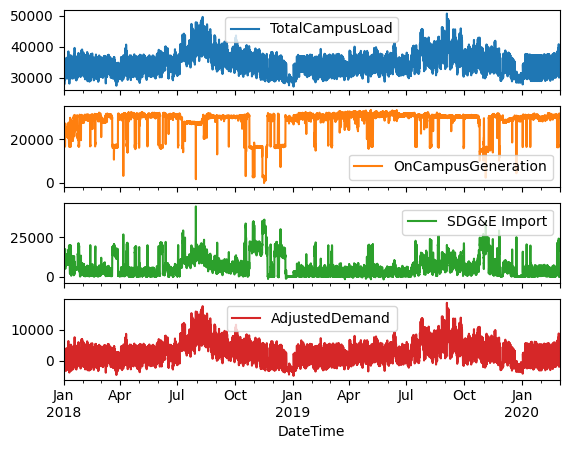

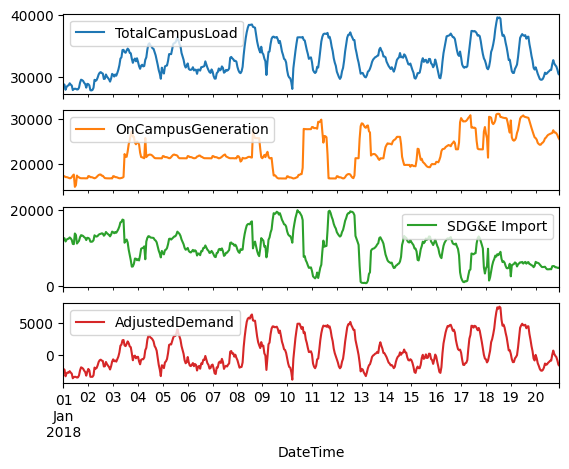

In [25]:
#plot the data set
plot_cols = ['TotalCampusLoad', 'OnCampusGeneration', 'SDG&E Import' , 'AdjustedDemand']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

In [26]:
#plot using plotly
plot_cols = ['TotalCampusLoad', 'OnCampusGeneration', 'SDG&E Import', 'AdjustedDemand']

# Create a separate figure for each column and plot it
for col in plot_cols:
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=date_time, y=df[col], mode='lines', name=col))
    fig.update_layout(
        title=f"Time Series Plot for {col}",
        xaxis_title="Date and Time",
        yaxis_title="Value",
        xaxis=dict(type='category'),  # Assuming your date_time is in the correct order
    )
    fig.show()

In [27]:
#plotting the box plot before normalizing the data
# Specify the columns for which you want to create box plots
plot_cols = ['TotalCampusLoad', 'OnCampusGeneration', 'SDG&E Import', 'AdjustedDemand']

# Create a DataFrame containing the selected columns
plot_df = df[plot_cols]

# Create box plots using Plotly Express
fig = px.box(plot_df, y=plot_df.columns, title="Box Plots for Features")
fig.update_xaxes(title_text="Columns")
fig.update_yaxes(title_text="Values")

# Show the plot
fig.show()

In [28]:
#now look at the statistics of the dataset
df.describe().transpose()

count          mean          std          min  \
TotalCampusLoad     18960.0  34416.182914  3454.482176  27050.71250   
OnCampusGeneration  18960.0  27929.123319  5624.431722    -71.56000   
SDG&E Import        18960.0   6435.467652  6458.984506  -1675.82850   
AdjustedDemand      18960.0   2408.590971  3468.762191  -4905.28625   

                             25%           50%           75%          max  
TotalCampusLoad     31703.673125  34029.373750  36587.182500  50714.30750  
OnCampusGeneration  28610.947875  30153.043875  30883.582000  33442.46000  
SDG&E Import         1393.167500   4658.690000   8869.670625  44185.94250  
AdjustedDemand       -329.547937   1973.000250   4604.402437  18758.30275

According to box plot it can see that statistics of  columns are different so it is good to normalize this data set for further implementations

In [29]:
#convert date time values to UNIX timestamps
timestamp_s = date_time.map(pd.Timestamp.timestamp)

In [30]:
#use sine and cosine transforms to clear "Time of day" and "Time of year" signals

day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

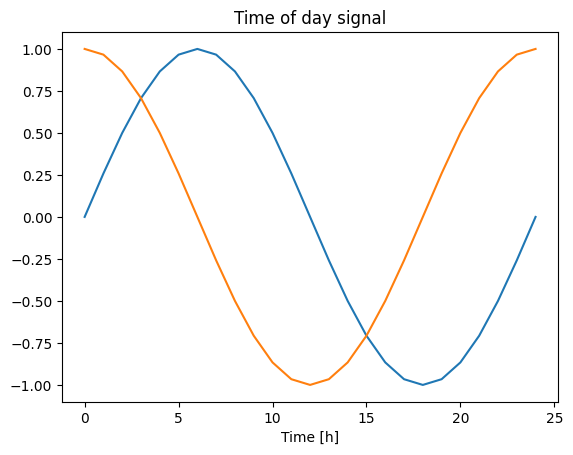

In [31]:
#plotting the date time signal
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [37]:
df.head()

TotalCampusLoad  OnCampusGeneration  SDG&E Import  \
DateTime                                                                 
2018-01-01 00:00:00       28790.9975         17229.75150    12566.2775   
2018-01-01 01:00:00       28703.2125         17192.15475    12489.3650   
2018-01-01 02:00:00       27887.5550         16997.35000    11656.6400   
2018-01-01 03:00:00       28342.3675         17001.70950    12125.6100   
2018-01-01 04:00:00       28537.3925         16932.71725    12328.6525   

                     AdjustedDemand       Day sin   Day cos  Year sin  \
DateTime                                                                
2018-01-01 00:00:00     -2159.97100 -2.389847e-12  1.000000  0.006193   
2018-01-01 01:00:00     -2274.48025  2.588190e-01  0.965926  0.006910   
2018-01-01 02:00:00     -3302.01000  5.000000e-01  0.866025  0.007626   
2018-01-01 03:00:00     -2828.68050  7.071068e-01  0.707107  0.008343   
2018-01-01 04:00:00     -2694.63025  8.660254e-01  0.500000  0.009060   

                     Year cos  
DateTime                       
2018-01-01 00:00:00  0.999981  
2018-01-01 01:00:00  0.999976  
2018-01-01 02:00:00  0.999971  
2018-01-01 03:00:00  0.999965  
2018-01-01 04:00:00  0.999959

##1.2 Splitting the data

In [32]:
##split data

#creating dictionry column_indices and assign unique index (i) to each column name (name) in the DataFrame
column_indices = {name: i for i, name in enumerate(df.columns)}

#split data into train, validation and testing
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

##1.3 Normalize the data

In [33]:
#normalize the data

#mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std


In [34]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1896 entries, 2019-12-13 00:00:00 to 2020-02-29 23:00:00
Freq: 60T
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   TotalCampusLoad     1896 non-null   float64
 1   OnCampusGeneration  1896 non-null   float64
 2   SDG&E Import        1896 non-null   float64
 3   AdjustedDemand      1896 non-null   float64
 4   Day sin             1896 non-null   float64
 5   Day cos             1896 non-null   float64
 6   Year sin            1896 non-null   float64
 7   Year cos            1896 non-null   float64
dtypes: float64(8)
memory usage: 133.3 KB


<ipython-input-35-0ee17fac0d6a>:6: UserWarning:

FixedFormatter should only be used together with FixedLocator



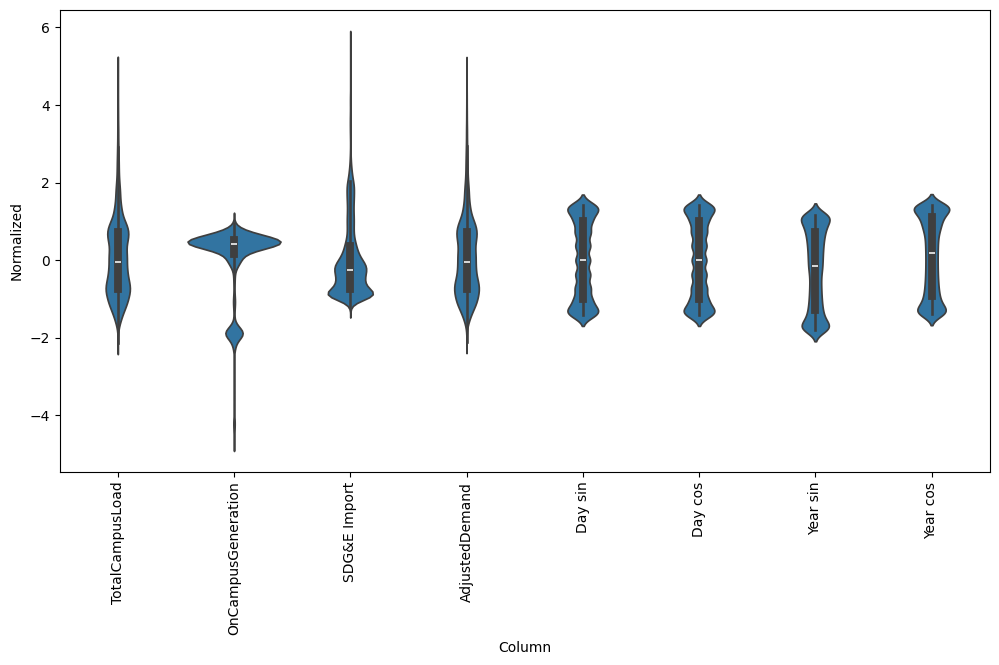

In [35]:
#violin plot on data set after normalization
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

#2 Data windowing

Implement data windowing. it includes \\
width of input and labels \\
time ofset and feature using \\
 \
Data windowing is a technique used in analyzing sequences of information. \
It involves breaking down a continuous set of data into smaller, manageable windows or segments. \
these windows are overlapping and they share data ponits.



In [38]:
#implementing data windowig

class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [39]:
#create a window for multy step models
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

#multi_window.plot()
multi_window

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

In [40]:
#column_indices

##2.1 Split

In [41]:
#split window convert generated window to a window of inputs and a window of labels.

def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

##2.2 plot

In [42]:
#simple visualization of the split window
def plot(self, model=None, plot_col='TotalCampusLoad', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

##2.3 Create tf.data.Datasets

In [43]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [44]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

#3 Packaged Traning Procedure

In multy step models we can forecst day ahead data. so accordingly we have to create window and models. \



##3.1 training model

In [45]:
import tensorflow as tf
# Define R squared (coefficient of determination) as a custom metric
def r_squared(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())

MAX_EPOCHS = 30

def compile_and_fit(model, window, patience=10):
    # Callback for early stopping with patience
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        mode='min',
        restore_best_weights=True  # Restore the best model weights upon early stopping
    )

    # Learning rate schedule
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=1000,
        decay_rate=0.9
    )

    # Adam optimizer with learning rate schedule
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    # Compile the model with mean squared error loss and mean absolute error metric
    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=optimizer,
        metrics=[tf.keras.metrics.MeanAbsoluteError(),r_squared ,tf.keras.metrics.RootMeanSquaredError()]
    )

    # Train the model
    history = model.fit(
        window.train,
        epochs=MAX_EPOCHS,
        validation_data=window.val,
        callbacks=[early_stopping]
    )

    return history


##3.2 Plotting function actual vs predicted

In [46]:
import plotly.graph_objects as go

def plot_actual_vs_predicted_all_datetime_plotly(self, model=None, plot_col='TotalCampusLoad'):
    inputs, labels = self.example
    plot_col_index = self.column_indices[plot_col]

    # If label_columns is specified, use label_columns indices, else use plot_col_index
    if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
        label_col_index = plot_col_index

    if label_col_index is None:
        return

    if model is not None:
        predictions = model(inputs).numpy()

    # Get all datetime values for the x-axis
    #datetime_values = self.val_df.index.to_numpy()
    datetime_values = self.test_df.index.to_numpy()

    # Create a Plotly figure
    fig = go.Figure()

    # Add traces for actual values
    fig.add_trace(go.Scatter(x=datetime_values, y=labels[:, :, label_col_index].numpy().flatten(),
                             mode='lines+markers', name='Actual'))

    # Add traces for predicted values if a model is provided
    if model is not None:
        fig.add_trace(go.Scatter(x=datetime_values, y=predictions[:, :, label_col_index].flatten(),
                                 mode='lines+markers', name='Predicted'))

    # Customize layout
    fig.update_layout(
        title=f'Actual vs Predicted ({plot_col})',
        xaxis_title='Time',
        yaxis_title=f'{plot_col} [normed]',
        showlegend=True
    )

    # Show the figure
    fig.show()

WindowGenerator.plot_actual_vs_predicted_all_datetime_plotly = plot_actual_vs_predicted_all_datetime_plotly

##3.3 Plot losses

In [47]:
def plot_losses(model_name, history):
    # Get training and validation losses
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    # Plot the losses
    epochs = range(1, len(training_loss) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, training_loss, 'b', label='Training Loss')
    plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
    plt.title(f'Training and Validation Loss for {model_name} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [48]:
def plot_losses_and_acc(model_name, history):
    # Get training and validation losses
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']
    training_acc = history.history['r_squared']
    validation_acc = history.history['r_squared']

    # Plot the losses
    epochs = range(1, len(training_loss) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, training_loss, 'b', label='Training Loss')
    plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
    plt.plot(epochs, training_acc, 'g', label='Train Accuracy')
    plt.plot(epochs, validation_acc, 'm',linestyle='dashed', label='Val Accuracy')
    plt.title(f'Training and Validation Loss for {model_name} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss & Accuracy')
    plt.legend()
    plt.show()

##3.4 R2 value for features

In [49]:
from sklearn.metrics import r2_score

def calculate_r2_value(actual_values, predicted_values):
    """
    Calculate R-squared value.

    Parameters:
    - actual_values (numpy array): Array of actual values.
    - predicted_values (numpy array): Array of predicted values.

    Returns:
    - float: R-squared value.
    """
    r_squared = r2_score(actual_values, predicted_values)
    return r_squared

def get_and_print_r2_values(model, window_generator):
    """
    Calculate and print R-squared values for all features.

    Parameters:
    - model: Trained model.
    - window_generator: WindowGenerator instance.
    """
    r_squared_values = []  # List to store R-squared values

    for feature in window_generator.column_indices.keys():
        if feature != 'Time':  # Exclude 'Time' column if it's present in column_indices
            label_col_index = window_generator.column_indices[feature]
            inputs, labels = window_generator.example
            predictions = model(inputs).numpy()
            predicted_values = predictions[:, :, label_col_index].flatten()

            # Calculate R-squared value
            r_squared_value = calculate_r2_value(labels[:, :, label_col_index].numpy().flatten(), predicted_values)
            r_squared_values.append((feature, r_squared_value))

            # Print R-squared value
            print(f'{feature}: {r_squared_value}')

    return r_squared_values

In [50]:
# Print loss values
name = ['loss/MSE','MAE','R2','RMSE']
def print_loss_values(model_name, indic):
    # Extract loss values

    # Print the loss values
    print(f"Training {name[indic]} for {model_name}: {multi_train_performance[model_name][indic]}")
    print(f"Validation {name[indic]} for {model_name}: {multi_val_performance[model_name][indic]}")
    print(f"Test {name[indic]} for {model_name}: {multi_test_performance[model_name][indic]}")

In [51]:
#store performance values
multi_train_performance = {}
multi_val_performance = {}
multi_test_performance = {}

#6 CNN Model

In [52]:
CONV_WIDTH = 8

CNN_model = tf.keras.Sequential([
    # Lambda layer to select the last CONV_WIDTH time steps
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    #tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, 4]),
    # Convolutional layer with ReLU activation and He initialization
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=CONV_WIDTH, kernel_initializer='he_normal'),
    # Batch Normalization layer
    tf.keras.layers.BatchNormalization(),
    # Dropout layer for regularization
    tf.keras.layers.Dropout(0.2),
    # Dense layer with linear activation and He initialization
    tf.keras.layers.Dense(OUT_STEPS*num_features, activation='linear', kernel_initializer='he_normal'),
    # Reshape layer to match the output shape
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

#history = compile_and_fit(CNN_model, multi_window)
history_CNN = compile_and_fit(CNN_model, multi_window)

IPython.display.clear_output()


##6.1 Evaluation and plot

118/118 [==============================] - 0s 3ms/step - loss: 0.1540 - mean_absolute_error: 0.1933 - r_squared: 0.8696 - root_mean_squared_error: 0.3925


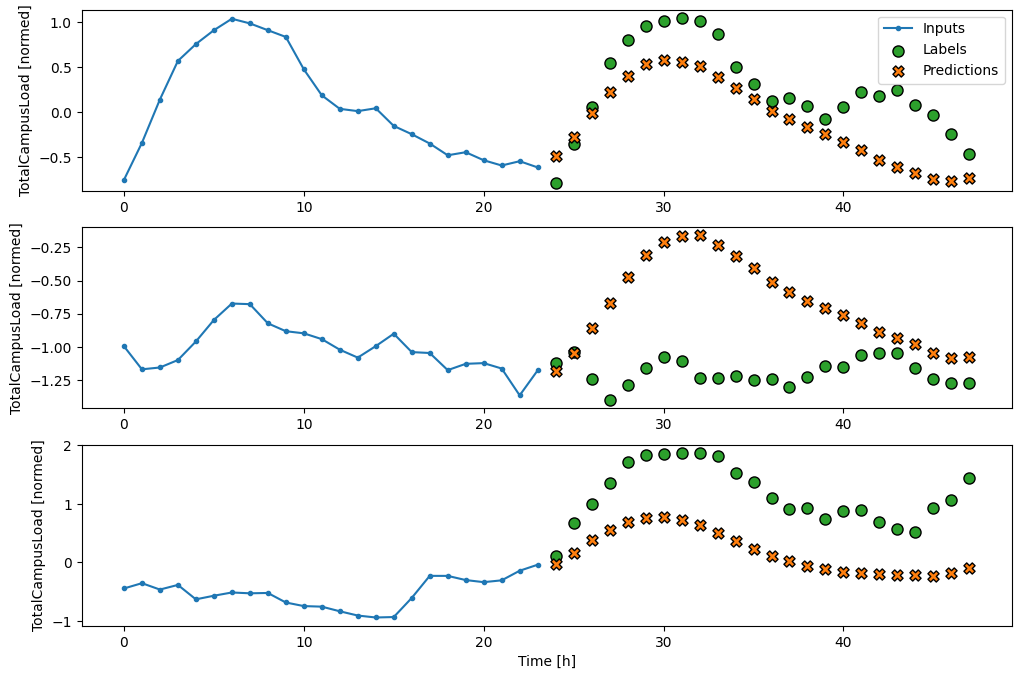

In [53]:
# Evaluate
multi_train_performance['CNN'] = CNN_model.evaluate(multi_window.train) #training data performance
multi_val_performance['CNN'] = CNN_model.evaluate(multi_window.val) #validation data performance
multi_test_performance['CNN'] = CNN_model.evaluate(multi_window.test, verbose=0) #test data performanve

# Plot the performance
multi_window.plot(CNN_model)

In [54]:
multi_window.plot_actual_vs_predicted_all_datetime_plotly(model=CNN_model, plot_col='TotalCampusLoad')

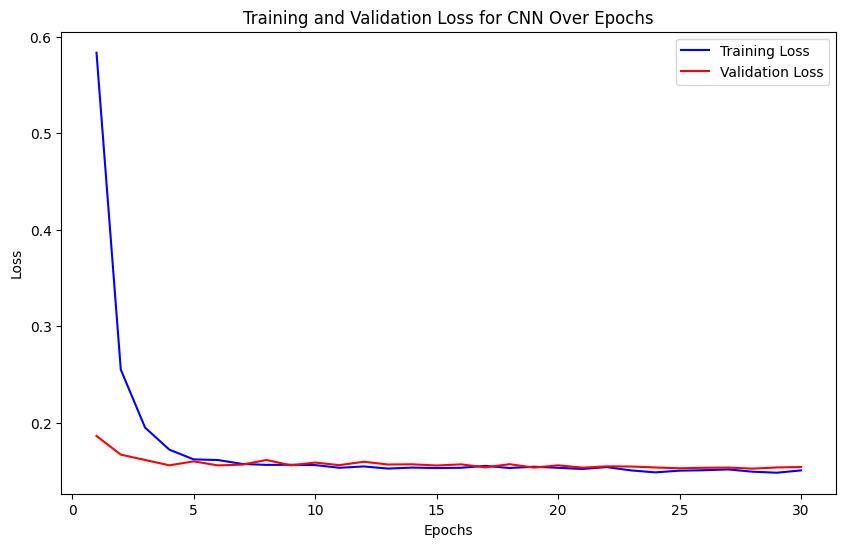

In [55]:
plot_losses('CNN', history_CNN)

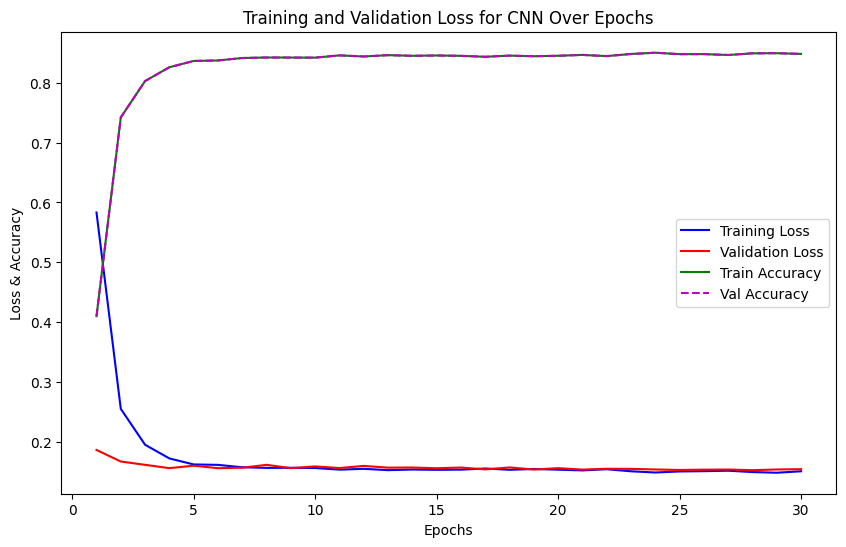

In [70]:
plot_losses_and_acc('CNN', history_CNN)

In [57]:
print_loss_values('CNN', 0)

Training loss/MSE for CNN: 0.10979027301073074
Validation loss/MSE for CNN: 0.15404149889945984
Test loss/MSE for CNN: 0.10383933782577515


In [58]:
print_loss_values('CNN', 1)

Training MAE for CNN: 0.16084171831607819
Validation MAE for CNN: 0.1932523101568222
Test MAE for CNN: 0.152353897690773


In [59]:
print_loss_values('CNN', 2)

Training R2 for CNN: 0.8890096545219421
Validation R2 for CNN: 0.8695865273475647
Test R2 for CNN: 0.8739830255508423


In [60]:
print_loss_values('CNN', 3)

Training RMSE for CNN: 0.33134618401527405
Validation RMSE for CNN: 0.3924812376499176
Test RMSE for CNN: 0.3222411572933197


In [61]:
r_squared_values_CNN = get_and_print_r2_values(model=CNN_model, window_generator=multi_window)

TotalCampusLoad: 0.7876560257371589
OnCampusGeneration: 0.19734378640713612
SDG&E Import: 0.3557799668731443
AdjustedDemand: 0.7899919166672007
Day sin: 0.9992205651195739
Day cos: 0.9992205677626191
Year sin: 0.9991778377634745
Year cos: 0.999192470892571


#7 Checking Performance

In [62]:
multi_train_performance

{'CNN': [0.10979027301073074,
  0.16084171831607819,
  0.8890096545219421,
  0.33134618401527405]}

In [63]:
multi_val_performance

{'CNN': [0.15404149889945984,
  0.1932523101568222,
  0.8695865273475647,
  0.3924812376499176]}

In [64]:
multi_test_performance

{'CNN': [0.10383933782577515,
  0.152353897690773,
  0.8739830255508423,
  0.3222411572933197]}

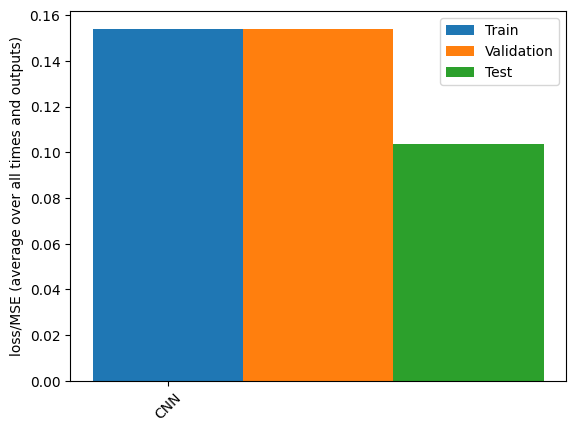

In [65]:
##mse comparsion
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(len(multi_test_performance))
width = 0.24

train_loss = [v[0] for v in multi_train_performance.values()]
val_loss = [v[0] for v in multi_val_performance.values()]
test_loss = [v[0] for v in multi_test_performance.values()]

plt.bar(x  , val_loss, width, label='Train')
plt.bar(x +width , val_loss, width, label='Validation')
plt.bar(x +(2*width), test_loss, width, label='Test')
plt.xticks(ticks=x, labels=multi_test_performance.keys(), rotation=45)
plt.ylabel(f'loss/MSE (average over all times and outputs)')
_ = plt.legend()
plt.show()

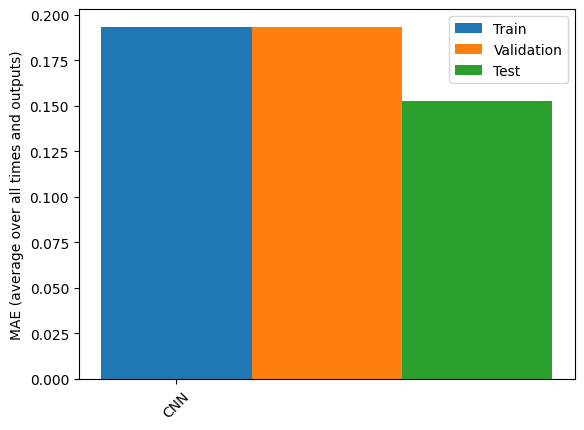

In [66]:
##mae comparsion
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(len(multi_test_performance))
width = 0.24

train_loss = [v[1] for v in multi_train_performance.values()]
val_loss = [v[1] for v in multi_val_performance.values()]
test_loss = [v[1] for v in multi_test_performance.values()]

plt.bar(x  , val_loss, width, label='Train')
plt.bar(x +width , val_loss, width, label='Validation')
plt.bar(x +(2*width), test_loss, width, label='Test')
plt.xticks(ticks=x, labels=multi_test_performance.keys(), rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()
plt.show()

In [67]:
import plotly.graph_objects as go

def plot_losses_multi(models, histories):
    # Create a Plotly figure
    fig = go.Figure()

    # Plot losses for each model
    for model_name, history in zip(models, histories):
        training_loss = history.history['loss']
        validation_loss = history.history['val_loss']

        # Plot training loss
        fig.add_trace(go.Scatter(x=list(range(1, len(training_loss) + 1)), y=training_loss,
                                 mode='lines',
                                 name=f'Training Loss ({model_name})'))

        # Plot validation loss
        fig.add_trace(go.Scatter(x=list(range(1, len(validation_loss) + 1)), y=validation_loss,
                                 mode='lines',
                                 name=f'Validation Loss ({model_name})'))

    # Layout settings
    fig.update_layout(title='Training and Validation Loss Over Epochs for Multiple Models',
                      xaxis=dict(title='Epochs'),
                      yaxis=dict(title='Loss'),
                      legend=dict(x=0, y=1, traceorder='normal', orientation='h'))

    # Show the plot
    fig.show()

In [72]:
plot_losses_multi(models=['CNN'], histories=[history_CNN])

#NO need to RUN


#4 Baseline model (Repeat)

In [ ]:
#create baseline model where it repeate the previous day values
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
history=repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError(),r_squared,tf.keras.metrics.RootMeanSquaredError(),])

#multi_val_performance = {}
#multi_performance = {}

#multi_val_performance['RepeatBaseline'] = repeat_baseline.evaluate(multi_window.val)
#multi_performance['RepeatBaseline'] = repeat_baseline.evaluate(multi_window.test, verbose=0)


##4.1 evalution and plot

118/118 [==============================] - 0s 3ms/step - loss: 0.2740 - mean_absolute_error: 0.2262 - r_squared: 0.7685 - root_mean_squared_error: 0.5235


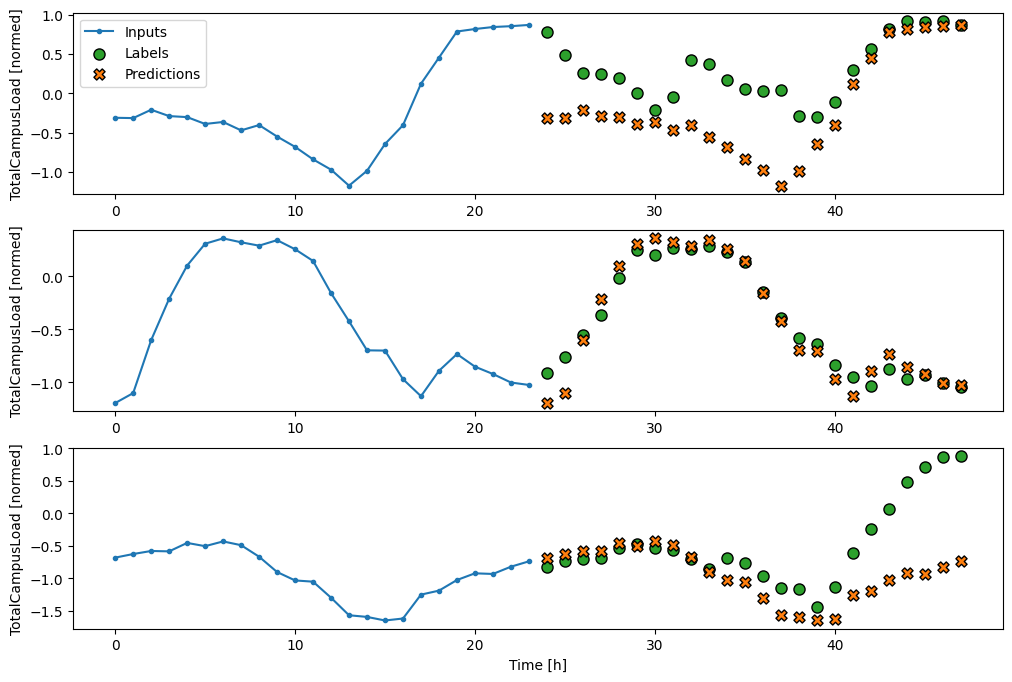

In [ ]:
multi_train_performance['R_Baseline'] = repeat_baseline.evaluate(multi_window.train)
multi_val_performance['R_Baseline'] = repeat_baseline.evaluate(multi_window.val)
multi_test_performance['R_Baseline'] = repeat_baseline.evaluate(multi_window.test, verbose=0) #verbose=0, the evaluation is performed quietly, and no progress or result information is printed

multi_window.plot(repeat_baseline)  ##plot the baseline model

In [ ]:
#multi_window.plot_actual_vs_predicted_all_datetime_plotly(model=RepeatBaseline, plot_col='TotalCampusLoad')

In [ ]:
#plot_losses('RepeatBaseline', history)

In [ ]:
print_loss_values('R_Baseline', 0)

Training loss/MSE for R_Baseline: 0.22097931802272797
Validation loss/MSE for R_Baseline: 0.27400174736976624
Test loss/MSE for R_Baseline: 0.16399769484996796


In [ ]:
print_loss_values('R_Baseline', 1)

Training MAE for R_Baseline: 0.19152727723121643
Validation MAE for R_Baseline: 0.226191908121109
Test MAE for R_Baseline: 0.14091435074806213


In [ ]:
print_loss_values('R_Baseline', 2)

Training R2 for R_Baseline: 0.7768186330795288
Validation R2 for R_Baseline: 0.7685023546218872
Test R2 for R_Baseline: 0.8009220361709595


In [ ]:
print_loss_values('R_Baseline', 3)

Training RMSE for R_Baseline: 0.47008469700813293
Validation RMSE for R_Baseline: 0.5234517455101013
Test RMSE for R_Baseline: 0.4049662947654724


In [ ]:
r_squared_values_base = get_and_print_r2_values(model=repeat_baseline, window_generator=multi_window)

TotalCampusLoad: 0.5949504102668923
OnCampusGeneration: 0.15975936655131828
SDG&E Import: 0.2710040840034682
AdjustedDemand: 0.550871162621013
Day sin: 1.0
Day cos: 1.0
Year sin: 0.9995974847324725
Year cos: 0.9996275322244218


#Baseline Average

In [ ]:
class AverageBaseline(tf.keras.Model):
    def call(self, inputs):
        # Calculate the average value along the last axis (assuming inputs is a tensor with time series data)
        average_value = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        # Repeat the average value along the last axis to match the shape of the input
        repeated_average = tf.tile(average_value, [1, 1, tf.shape(inputs)[-1]])
        return repeated_average

# Creating an instance of the AverageBaseline model
average_baseline = AverageBaseline()

# Compiling the model with a Mean Squared Error loss function and some evaluation metrics
history = average_baseline.compile(
    loss=tf.keras.losses.MeanSquaredError(),  # Mean Squared Error loss function
    metrics=[
        tf.keras.metrics.MeanAbsoluteError(),  # Mean Absolute Error metric
        r_squared,
        tf.keras.metrics.RootMeanSquaredError(),  # Root Mean Squared Error metric
    ]
)

##Evaluate and plot

118/118 [==============================] - 0s 3ms/step - loss: 1.1583 - mean_absolute_error: 0.8784 - r_squared: 0.0150 - root_mean_squared_error: 1.0762


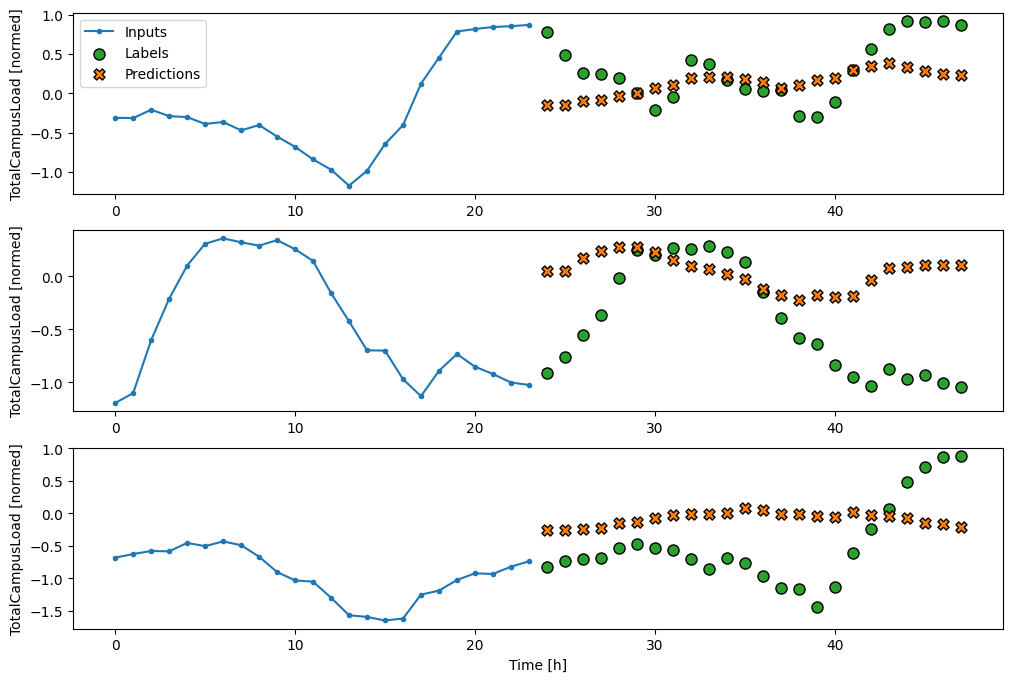

In [ ]:
multi_train_performance['A_Baseline'] = average_baseline.evaluate(multi_window.train)
multi_val_performance['A_Baseline'] = average_baseline.evaluate(multi_window.val)
multi_test_performance['A_Baseline'] = average_baseline.evaluate(multi_window.test, verbose=0) #verbose=0, the evaluation is performed quietly, and no progress or result information is printed

multi_window.plot(average_baseline)  ##plot the baseline model

In [ ]:
print_loss_values('A_Baseline', 0)

Training loss/MSE for A_Baseline: 0.9758687615394592
Validation loss/MSE for A_Baseline: 1.1582744121551514
Test loss/MSE for A_Baseline: 0.7976729869842529


In [ ]:
print_loss_values('A_Baseline', 1)

Training MAE for A_Baseline: 0.8178314566612244
Validation MAE for A_Baseline: 0.8783555030822754
Test MAE for A_Baseline: 0.7558139562606812


In [ ]:
print_loss_values('A_Baseline', 2)

Training R2 for A_Baseline: 0.021220488473773003
Validation R2 for A_Baseline: 0.01504385657608509
Test R2 for A_Baseline: 0.031225085258483887


In [ ]:
print_loss_values('A_Baseline', 3)

Training RMSE for A_Baseline: 0.987860381603241
Validation RMSE for A_Baseline: 1.076231598854065
Test RMSE for A_Baseline: 0.8931252956390381


#Sesonal baseline

In [ ]:
class SeasonalNaiveBaseline(tf.keras.Model):
    def call(self, inputs):
        # Assuming inputs is a tensor with the shape (batch_size, sequence_length, features)

        # Extract the last observed value for each season (last value of each sequence)
        last_observed_value = inputs[:, -1, :]

        # Repeat the last observed value along the sequence length to match the input shape
        repeated_last_observed = tf.tile(last_observed_value[:, tf.newaxis, :], [1, tf.shape(inputs)[1], 1])

        return repeated_last_observed

# Creating an instance of the SeasonalNaiveBaseline model
seasonal_naive_baseline = SeasonalNaiveBaseline()

# Compiling the model with a Mean Squared Error loss function and some evaluation metrics
history = seasonal_naive_baseline.compile(
    loss=tf.keras.losses.MeanSquaredError(),  # Mean Squared Error loss function
    metrics=[
        tf.keras.metrics.MeanAbsoluteError(),  # Mean Absolute Error metric
        tf.keras.metrics.RootMeanSquaredError(),  # Root Mean Squared Error metric
    ]
)

##Evaluate and Plot

118/118 [==============================] - 0s 3ms/step - loss: 0.8710 - mean_absolute_error: 0.5725 - root_mean_squared_error: 0.9333


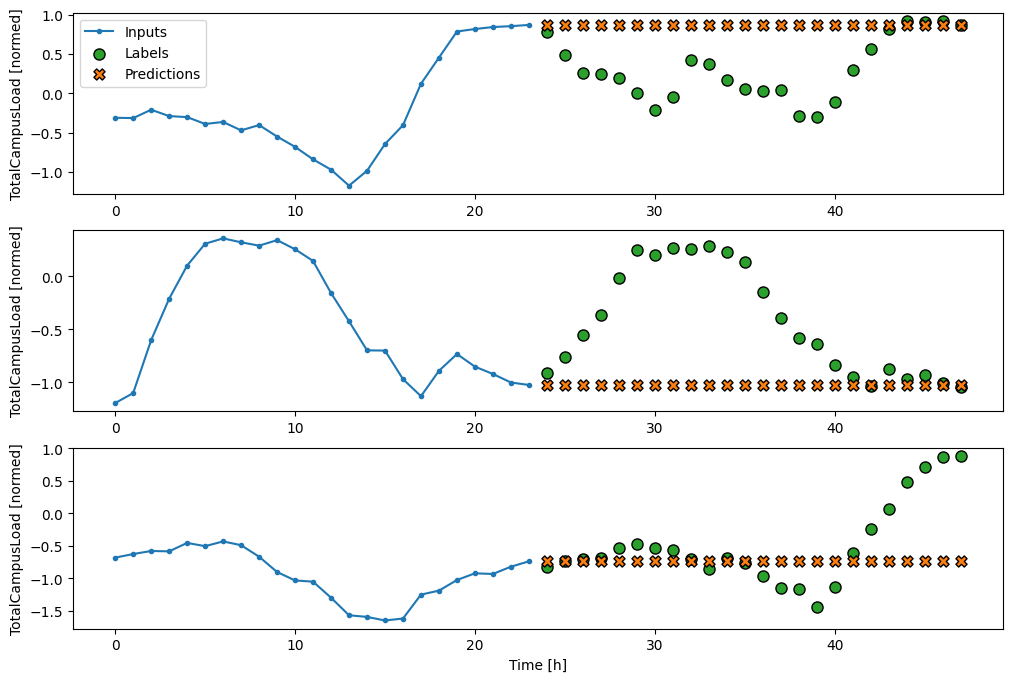

In [ ]:
multi_train_performance['Season_B'] = seasonal_naive_baseline.evaluate(multi_window.train)
multi_val_performance['Season_B'] = seasonal_naive_baseline.evaluate(multi_window.val)
multi_test_performance['Season_B'] = seasonal_naive_baseline.evaluate(multi_window.test, verbose=0) #verbose=0, the evaluation is performed quietly, and no progress or result information is printed

multi_window.plot(seasonal_naive_baseline)  ##plot the baseline model

#ARMA model

In [ ]:
import tensorflow as tf

class ARMA(tf.keras.Model):
    def __init__(self, order):
        super(ARMA, self).__init__()
        self.order = order
        self.autoregressive = tf.keras.layers.Dense(1, activation=None, use_bias=False)
        self.moving_average = tf.keras.layers.Dense(1, activation=None)

    def call(self, inputs):
        # Assuming inputs is a tensor with shape (batch_size, sequence_length, features)

        # Autoregressive (AR) component
        ar_component = self.autoregressive(inputs[:, -self.order:, :])

        # Moving Average (MA) component
        ma_component = self.moving_average(inputs)

        # Combine AR and MA components to get the final prediction
        prediction = ar_component + ma_component

        return prediction

# Creating an instance of the ARMA model with order (p=1, q=1)
arma_model = ARMA(order=1)

# Compiling the model with a Mean Squared Error loss function and some evaluation metrics
history_ARMA = compile_and_fit(arma_model, multi_window)

IPython.display.clear_output()


##Evaluate and Plot

118/118 [==============================] - 1s 4ms/step - loss: 1.1424 - mean_absolute_error: 0.8740 - r_squared: 0.0284 - root_mean_squared_error: 1.0688


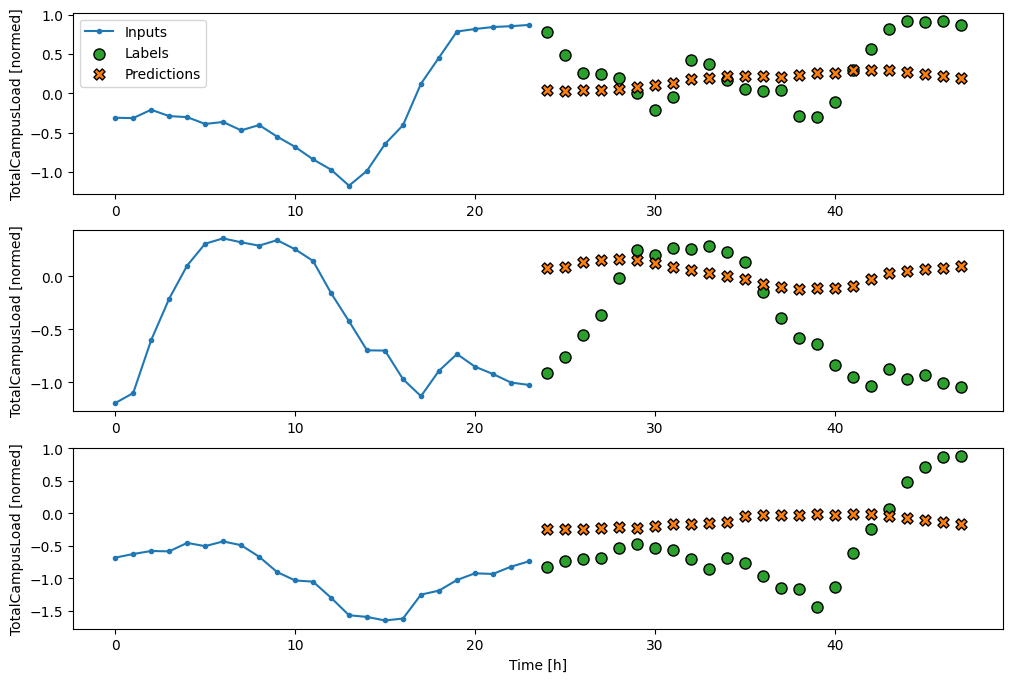

In [ ]:
# Evaluate
multi_train_performance['ARMA'] = arma_model.evaluate(multi_window.train) #training data performance
multi_val_performance['ARMA'] = arma_model.evaluate(multi_window.val) #validation data performance
multi_test_performance['ARMA'] = arma_model.evaluate(multi_window.test, verbose=0) #test data performanve

# Plot the performance
multi_window.plot(arma_model)

In [ ]:
multi_window.plot_actual_vs_predicted_all_datetime_plotly(model=arma_model, plot_col='TotalCampusLoad')

In [ ]:
print_loss_values('ARMA', 0)

Training loss/MSE for ARMA: 0.9647859334945679
Validation loss/MSE for ARMA: 1.1424254179000854
Test loss/MSE for ARMA: 0.7998837232589722


In [ ]:
print_loss_values('ARMA', 1)

Training MAE for ARMA: 0.8154984712600708
Validation MAE for ARMA: 0.8740403652191162
Test MAE for ARMA: 0.7611666321754456


In [ ]:
print_loss_values('ARMA', 2)

Training R2 for ARMA: 0.03244217857718468
Validation R2 for ARMA: 0.02839396893978119
Test R2 for ARMA: 0.028878072276711464


In [ ]:
print_loss_values('ARMA', 3)

Training RMSE for ARMA: 0.9822348952293396
Validation RMSE for ARMA: 1.0688432455062866
Test RMSE for ARMA: 0.894362211227417


#ARIMA model

In [ ]:
import statsmodels.api as sm

class ARIMA(tf.keras.Model):
    def __init__(self, p, d, q):
        super(ARIMA, self).__init__()
        self.p = p
        self.d = d
        self.q = q

    def call(self, inputs):
        # ARIMA doesn't have a typical 'call' method for prediction like neural networks
        return inputs

    def train(self, train_data):
        # Convert the input tensor to a numpy array for compatibility with statsmodels
        data = np.asarray(train_data[:, :, 0])

        # Fit ARIMA model using statsmodels
        arima_model = sm.tsa.ARIMA(data[0], order=(self.p, self.d, self.q))
        arima_results = arima_model.fit()

        # Optionally, save the ARIMA results or model for future use

        return arima_results

# Creating an instance of the ARIMA model with order (p=1, d=1, q=1)
arima_model = ARIMA(p=1, d=1, q=1)

history_ARIMA = compile_and_fit(arima_model, multi_window)

IPython.display.clear_output()

##Evaluate and Plot

118/118 [==============================] - 0s 3ms/step - loss: 0.2740 - mean_absolute_error: 0.2262 - r_squared: 0.7670 - root_mean_squared_error: 0.5235


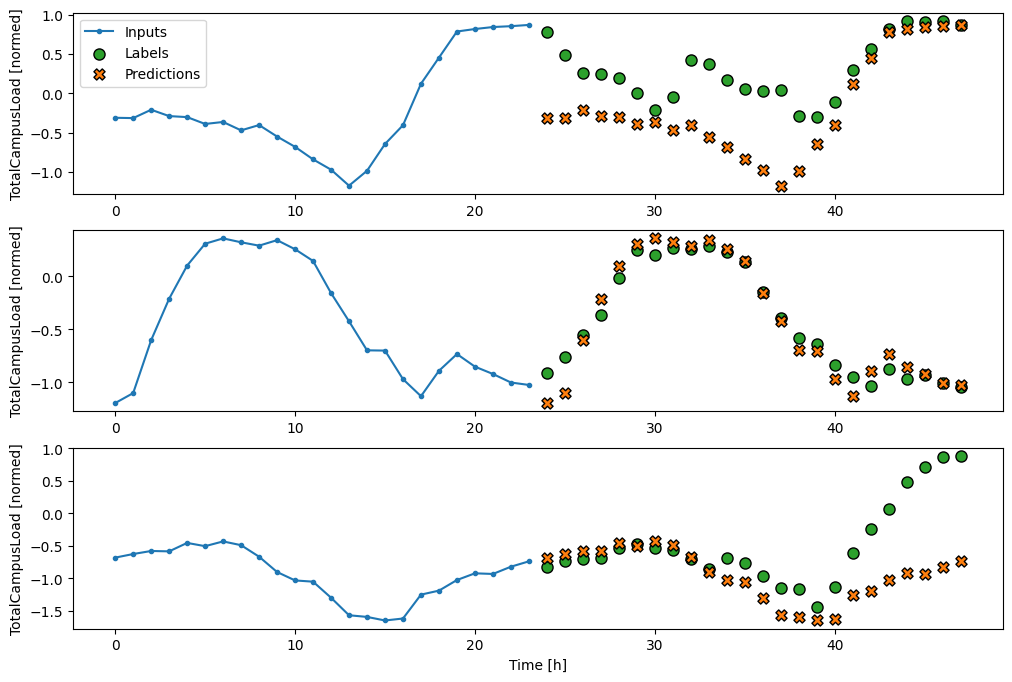

In [ ]:
# Evaluate
multi_train_performance['ARIMA'] = arima_model.evaluate(multi_window.train) #training data performance
multi_val_performance['ARIMA'] = arima_model.evaluate(multi_window.val) #validation data performance
multi_test_performance['ARIMA'] = arima_model.evaluate(multi_window.test, verbose=0) #test data performanve

# Plot the performance
multi_window.plot(arima_model)

In [ ]:
multi_window.plot_actual_vs_predicted_all_datetime_plotly(model=arima_model, plot_col='TotalCampusLoad')

In [ ]:
print_loss_values('ARIMA', 0)

Training loss/MSE for ARIMA: 0.22097954154014587
Validation loss/MSE for ARIMA: 0.2740016579627991
Test loss/MSE for ARIMA: 0.16399772465229034


In [ ]:
print_loss_values('ARIMA', 1)

Training MAE for ARIMA: 0.19152730703353882
Validation MAE for ARIMA: 0.22619198262691498
Test MAE for ARIMA: 0.14091433584690094


In [ ]:
print_loss_values('ARIMA', 2)

Training R2 for ARIMA: 0.7769262194633484
Validation R2 for ARIMA: 0.7670153379440308
Test R2 for ARIMA: 0.8008713722229004


In [ ]:
print_loss_values('ARIMA', 3)

Training RMSE for ARIMA: 0.4700845777988434
Validation RMSE for ARIMA: 0.5234517455101013
Test RMSE for ARIMA: 0.4049662947654724


#5 CNN model_1D

In [ ]:
##create CNN model which makes predictions based on a fixed-width history

CONV_WIDTH = 5
CNN_model_1D = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    #tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, 4]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    #tf.keras.layers.Dense(OUT_STEPS*num_features,activation='linear',kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Dense(OUT_STEPS*num_features,activation='linear',kernel_initializer='he_normal'),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

#history = compile_and_fit(CNN_model_1D, multi_window)
history_1Dcnn = compile_and_fit(CNN_model_1D, multi_window)

IPython.display.clear_output()

#multi_val_performance['CNN'] = multi_conv_model.evaluate(multi_window.val)
#multi_performance['CNN'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
#multi_window.plot(multi_conv_model)


##5.1 Evaluation and plot

118/118 [==============================] - 0s 3ms/step - loss: 0.1553 - mean_absolute_error: 0.1916 - r_squared: 0.8676 - root_mean_squared_error: 0.3940


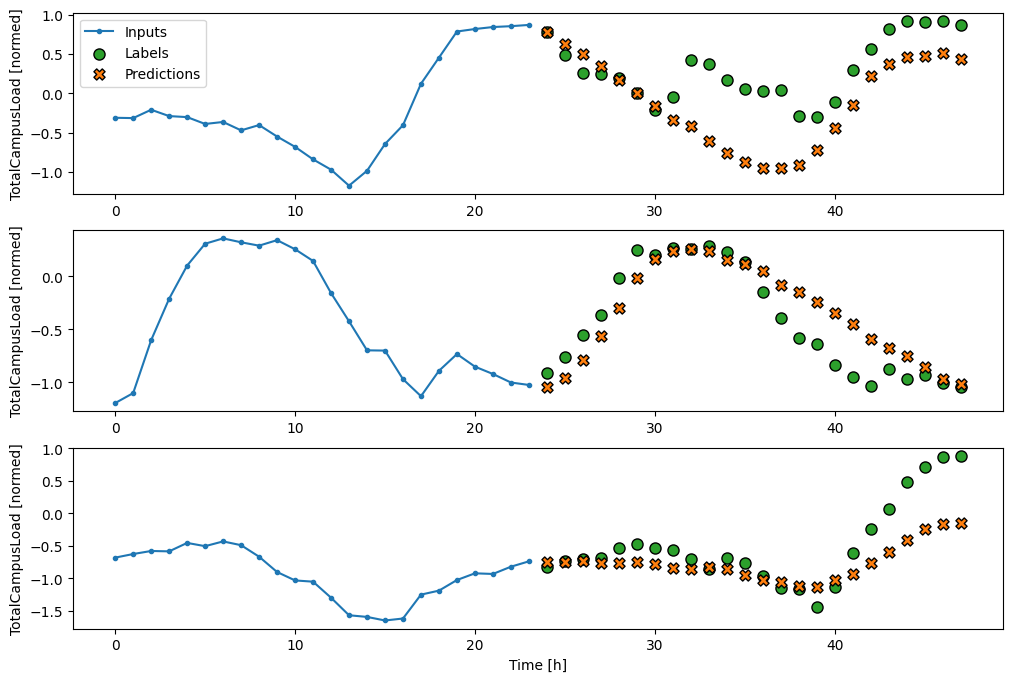

In [ ]:
# Evaluate
multi_train_performance['CNN_1D'] = CNN_model_1D.evaluate(multi_window.train) #training data performance
multi_val_performance['CNN_1D'] = CNN_model_1D.evaluate(multi_window.val) #validation data performance
multi_test_performance['CNN_1D'] = CNN_model_1D.evaluate(multi_window.test, verbose=0) #test data performanve

# Plot the performance
multi_window.plot(CNN_model_1D)

In [ ]:
multi_window.plot_actual_vs_predicted_all_datetime_plotly(model=CNN_model_1D, plot_col='TotalCampusLoad')

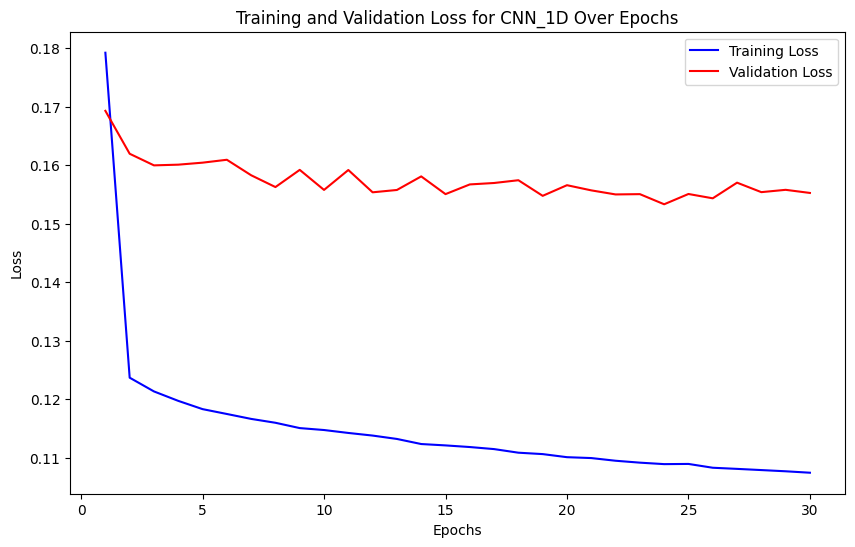

In [ ]:
plot_losses('CNN_1D', history_1Dcnn)

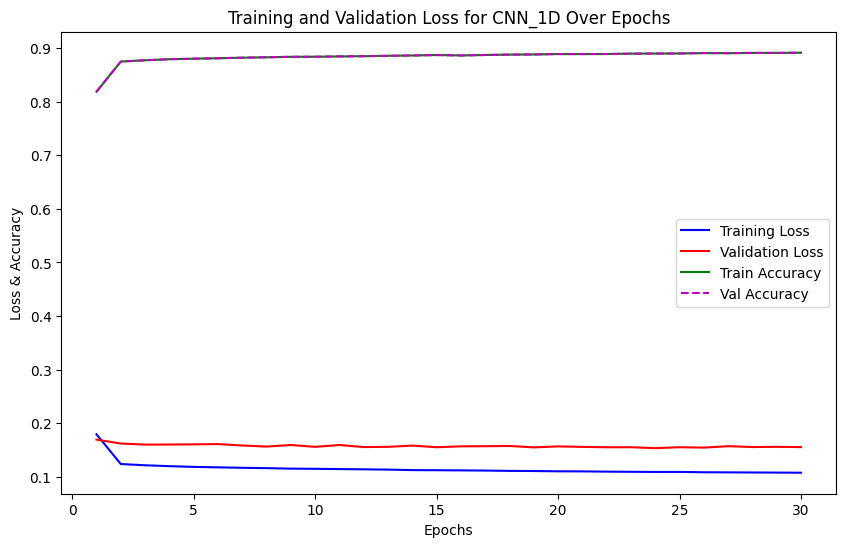

In [ ]:
plot_losses_and_acc('CNN_1D', history_1Dcnn)

In [ ]:
print_loss_values('CNN_1D', 0)

Training loss/MSE for CNN_1D: 0.10685853660106659
Validation loss/MSE for CNN_1D: 0.15526513755321503
Test loss/MSE for CNN_1D: 0.10634713619947433


In [ ]:
print_loss_values('CNN_1D', 1)

Training MAE for CNN_1D: 0.15484420955181122
Validation MAE for CNN_1D: 0.19157667458057404
Test MAE for CNN_1D: 0.14621201157569885


In [ ]:
print_loss_values('CNN_1D', 2)

Training R2 for CNN_1D: 0.8919515013694763
Validation R2 for CNN_1D: 0.8675938844680786
Test R2 for CNN_1D: 0.871174693107605


In [ ]:
print_loss_values('CNN_1D', 3)

Training RMSE for CNN_1D: 0.326892226934433
Validation RMSE for CNN_1D: 0.3940370976924896
Test RMSE for CNN_1D: 0.3261091113090515


In [ ]:
r_squared_values_CNN_1D = get_and_print_r2_values(model=CNN_model_1D, window_generator=multi_window)

TotalCampusLoad: 0.8382705022943873
OnCampusGeneration: 0.7947547110764905
SDG&E Import: 0.7720433203207224
AdjustedDemand: 0.8222602026237513
Day sin: 0.9996942778205217
Day cos: 0.9996948093143615
Year sin: 0.9997316750683519
Year cos: 0.9997084176696692
